In [1]:
%%capture
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
!pip install openpyxl

In [2]:
max_calculated = pd.read_csv('max_calculated.csv')
max_elemental = pd.read_csv('max_elemental.csv')
list_mxene = pd.read_excel('synthesized-MXenes-MAX.xlsx',sheet_name=0)
list_failed = pd.read_excel('synthesized-MXenes-MAX.xlsx', sheet_name=2)
n_samples = max_elemental.shape[0]
synth_list = pd.unique(list_mxene['MXene'])[:-1]
to_drop = list(range(167,173))
mx_ene_df = list_mxene.drop(labels = to_drop, axis='index')
mx_ene_df = mx_ene_df.drop(['Unnamed: 9','Unnamed: 12','Notes','status','Reference method'],axis=1)
max_elemental['class'] = np.zeros(max_elemental.shape[0])
parents = mx_ene_df['Parent material'].unique()
banned_words = ['+','Mxene','topochemical','reaction', 'or',
               'synthesis','MXene','direct']
complete_parents = []
for i in range(len(parents)):
    inter = parents[i].split()
    for word in range(len(inter)):
        if inter[word] not in banned_words:
            complete_parents.append(inter[word])


for i in range(max_elemental.shape[0]):
    if max_elemental.loc[i,'compound_formula'] in complete_parents:
        max_elemental.loc[i,'class'] = 1

max_elemental = max_elemental.set_index('compound_formula',drop=True)
max_elemental = max_elemental.drop(['M_element', 'A_element', 'X_element'],axis=1)
max_calculated = max_calculated.set_index('prettyformula',drop=True)
whole_data = max_elemental.merge(max_calculated,how='inner',
                                 left_index=True,right_index=True)

In [3]:
svm = pd.read_csv('it_ls_svm_all_features.csv')
bagging = pd.read_csv('ordered_predictions_bagging_svm_15_all_features.csv')

In [4]:
svm = svm.filter(items=['compound_name'],axis=1)

In [5]:
svm['rank_svm'] = svm.index

In [6]:
bagging = bagging.drop(['score_bagging'],axis=1)
#bagging : compound_name
#svm : 

In [7]:
list_svm = list(svm['compound_name'])
list_bagging = list(bagging['compound_name'])

In [8]:
list_common = []
common = 0
for i in list_svm:
    if i in list_bagging:
        list_common.append(i)

In [9]:
list_common

['Nb2SC',
 'Ta2NiN',
 'Ti2OsC',
 'Zr2RuC',
 'Ta2CoN',
 'Ta2CoC',
 'Ta2NiC',
 'Ta2FeN',
 'Ta2MnC',
 'Ta2CuC',
 'Nb2PC',
 'Nb2ReN',
 'W2OsN',
 'W2PtC',
 'Ta2GeC',
 'Nb2OsN',
 'Nb2PtC',
 'Hf2NiC',
 'W2ReC',
 'W2IrC',
 'Nb2OsC',
 'Ta2SiN',
 'Zr2SiC',
 'Zr2RhC',
 'Ti2IrC',
 'Ta2PdC',
 'Ta2RhN',
 'Hf2RhC',
 'Nb2IrC',
 'Ta2AsC',
 'Ta2IrN',
 'Hf2IrC',
 'Zr2PtC',
 'Hf2SiC',
 'Ta2OsN',
 'Ta2PtC',
 'Hf2PtC',
 'Ta2PtN',
 'Nb2IrN',
 'Ta2SeC',
 'Ta2FeC',
 'Ti2ReC',
 'Ta2SC',
 'Zr2IrC',
 'Hf2GeC',
 'Hf2AsC',
 'W2OsC',
 'Nb2ReC',
 'Ta2GaC',
 'Ta2SiC',
 'Zr2OsN',
 'Zr2ReC',
 'Hf2ReN',
 'Ti2OsN',
 'Zr2RuN',
 'V2IrC',
 'V2OsC',
 'Hf2RuC',
 'Zr2IrN',
 'Hf2RuN',
 'Nb2SiC',
 'Ta2IrC',
 'Ta2OsC',
 'Re2OsC']

In [10]:
positive_ones = whole_data[whole_data['class'] == 1]
positive_ones = positive_ones.filter(['dH','dEf'],axis=1)

In [11]:
max_bagg = max_calculated.filter(items=list_bagging,axis=0)
max_it = max_calculated.filter(items=list_svm,axis=0)

In [12]:
max_bagg = max_bagg.filter(['dH','dEf'],axis=1)
max_it = max_it.filter(['dH','dEf'],axis=1)
if len(list_common)>0:
    max_bagg = max_bagg.drop(list_common,axis=0)
    max_it = max_it.drop(list_common,axis=0)
    common_retained = max_calculated.filter(items=list_common,axis=0)

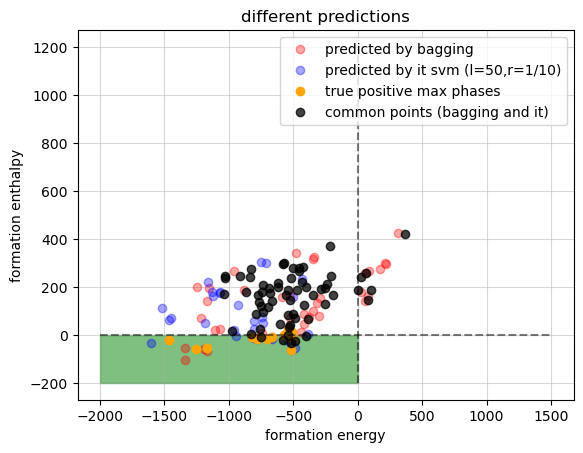

In [14]:
fig, ax = plt.subplots()
ax.plot(max_bagg['dEf'].to_numpy(),max_bagg['dH'].to_numpy(), 'o',
       alpha=0.35,color='red',label='predicted by bagging')
ax.plot(max_it['dEf'].to_numpy(),max_it['dH'].to_numpy(), 'o',
       alpha=0.35,color='blue',label='predicted by it svm (l=50,r=1/10)')
ax.plot(positive_ones['dEf'].to_numpy(),positive_ones['dH'].to_numpy(), 'o',
        color='orange',label='true positive max phases')
if len(list_common)>0:
    ax.plot(common_retained['dEf'].to_numpy(),common_retained['dH'].to_numpy(), 'ko',
            label='common points (bagging and it)',alpha=0.74)
ax.fill_between(np.linspace(-2000,0,2,endpoint=True),
                y1=-200,y2=0,color='green',alpha=0.5)
ax.plot(np.linspace(-2000,1500,2,endpoint=True),np.zeros(2),'--k',alpha=0.5)
ax.plot(np.zeros(2),np.linspace(-200,1200,2,endpoint=True),'--k',alpha=0.5)
ax.grid(alpha=0.5)
ax.set_xlabel(xlabel='formation energy')
ax.set_ylabel(ylabel='formation enthalpy')
ax.set_title('different predictions')
plt.legend()      
plt.savefig('diff_pred_50_10_cl_elem.png')